# House Prices: Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting <br/>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques'

### Useful links (hopefully)
* City of Ames map - https://www.cityofames.org/home/showdocument?id=1024
* Extensive data documentation - https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt
* Website to search for exact geographical locations of neighborhoods (colors on the Ames map are confusing) - https://www.realtor.com/local/Crawford_Ames_IA

In [1]:
%load_ext Cython
import math
from operator import itemgetter
from itertools import combinations
from collections import OrderedDict
from functools import partial
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from terminaltables import AsciiTable
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.feature_selection import f_regression

We start by examining the data.

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
try:
    df = df.set_index('Id')
except KeyError:
    pass
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [4]:
all_vars = df.columns.values.tolist()
excluded_vars = []
cat_cols = df.select_dtypes('object').columns.values.tolist()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = df.drop('SalePrice', axis=1).select_dtypes(include=numerics).columns.values.tolist()

Let's get a list of all NA columns

In [5]:
na_cat_cols = df.columns.values[df.isna().any()].tolist()

In [6]:
print(set(cat_cols) - set(na_cat_cols))

{'Condition2', 'Exterior2nd', 'Utilities', 'Heating', 'MSZoning', 'CentralAir', 'Exterior1st', 'HeatingQC', 'Neighborhood', 'LandContour', 'RoofStyle', 'PavedDrive', 'BldgType', 'LandSlope', 'KitchenQual', 'ExterQual', 'SaleType', 'HouseStyle', 'Condition1', 'SaleCondition', 'RoofMatl', 'Foundation', 'LotConfig', 'LotShape', 'ExterCond', 'Functional', 'Street'}


In [7]:
skew = df[numeric_cols].skew()
print(skew)
skewed_features = [s for s in skew if(s > 5.0)]
for skf in skewed_features:
    sk = skew[skew == skf].index[0]
    df[sk] = np.log1p(df[sk])

MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
dtype: float64


Now from the dataset description, we the following variable type distribution:
* Continuous variables are: LotFrontage, MasVnrArea
* Discrete variables are: GarageYrBlt
* Ordinal variables are: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu, GarageFinish, GarageQual, GarageCond, PoolQC, Fence
* Nominal variables are: Alley, MasVnrType, GarageType, MiscFeature

Nominal variables can not be cleaned or used, hence they are dropped. NAs in a discrete variable GarageYrBlt can not be filled either, because it is impossible to give a meaningful value for the year when the garage was built. NAs in ordinal variables mean the absence of features, so they should not be refilled, but rather casted to the 0 label when encoding the labels. Continuous variables are filled with median values

In [8]:
tp_qual  = pd.api.types.CategoricalDtype(categories=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                         ordered=True)
tp_rat   = pd.api.types.CategoricalDtype(categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                                         ordered=True)
tp_exp   = pd.api.types.CategoricalDtype(categories=['NA', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
tp_fence = pd.api.types.CategoricalDtype(categories=['NA', 'MnWv', 'GdWo', 'MnPrv', 'GdPrv'], ordered=True)
tp_fin   = pd.api.types.CategoricalDtype(categories=['NA', 'Unf', 'RFn', 'Fin'], ordered=True)

na_ordinal_vars = OrderedDict({
 'BsmtQual': tp_qual, 'BsmtCond': tp_qual, 'BsmtExposure': tp_exp, 'BsmtFinType1': tp_rat, 'BsmtFinType2': tp_rat,
 'FireplaceQu': tp_qual, 'PoolQC': tp_qual, 'Fence': tp_fence,
 'GarageFinish': tp_fin, 'GarageQual': tp_qual, 'GarageCond': tp_qual
})

na_nominal_vars = ['Alley', 'MasVnrType', 'GarageType', 'MiscFeature', 'GarageYrBlt']

na_cont_vars = ['LotFrontage', 'MasVnrArea']

df_no_na = df.drop(na_nominal_vars[0], axis=1)
for nnv in na_nominal_vars[1:]:
    df_no_na.drop(nnv, axis=1, inplace=True)

df_no_na.drop('Electrical', axis=1, inplace=True)
for nov in na_ordinal_vars:
    df_no_na[nov].fillna('NA', inplace=True)
    df_no_na[nov] = df_no_na[nov].astype(na_ordinal_vars[nov]).cat.codes
    
for ncv in na_cont_vars:
    df_no_na[ncv].fillna(df_no_na[ncv].median(), inplace=True)

In [9]:
has_na = df_no_na.isna().any()
if sum(has_na):
    print(has_na[has_na])
else:
    print("No NAs detected!")

No NAs detected!


Exploring categorical features without missing values:
* Ordinal variables are: 'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond'
* Nominal variables are: 'MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation'

Nominal variables are converted into identifiers in an individual manner.

In [10]:
tp_shape = pd.api.types.CategoricalDtype(categories=['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
tp_util  = pd.api.types.CategoricalDtype(categories=['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True)
tp_slope = pd.api.types.CategoricalDtype(categories=['Sev', 'Mod', 'Gtl'], ordered=True)
tp_paved = pd.api.types.CategoricalDtype(categories=['N', 'P', 'Y'], ordered=True)
tp_func  = pd.api.types.CategoricalDtype(categories=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                                         ordered=True)

ordinal_vars = OrderedDict({
    'LotShape': tp_shape, 'Utilities': tp_util, 'KitchenQual': tp_qual, 'HeatingQC': tp_qual,
    'LandSlope': tp_slope, 'ExterQual': tp_qual, 'ExterCond': tp_qual, 'PavedDrive': tp_paved,
    'Functional': tp_func, 
})

nominal_vars = ['MSZoning', 'Street', 'LandContour', 'LotConfig', 'CentralAir', 'Neighborhood',
                'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'SaleType',
                'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleCondition']

for ov in ordinal_vars:
    df_no_na[ov] = df_no_na[ov].astype(ordinal_vars[ov]).cat.codes

In [11]:
cont_or_discrete_vars = list(
    set(all_vars) - set(nominal_vars) - set(ordinal_vars.keys()) -
    set(na_ordinal_vars) - set(na_nominal_vars) - set(['Electrical', 'SalePrice'])
)

Now let's continue with feature engineering combining the existing features in various ways.

In [12]:
df_no_na['Bsmt'] = (df_no_na['BsmtFinSF1'] * df_no_na['BsmtFinType1'] + 
                    df_no_na['BsmtFinSF2'] * df_no_na['BsmtFinType2'])
df_no_na['BldAge'] = (df_no_na['YrSold'] - df_no_na['YearRemodAdd']).clip(lower=0)
df_no_na['RenovationAfter'] = df_no_na['YearRemodAdd'] - df_no_na['YearBuilt']
# df_no_na['Lot'] = df_no_na['LotFrontage'] + df_no_na['LotArea'] -- useless

def mssub2class(sc):
    """
    Collapsing subclasses of dwellings into the coarser classes
      => label 0 -- 1, 2, 2-1/2 dwellings
      => label 1 -- 1-1/2 dwellings
      => label 2 -- SPLIT dwellings
      => label 3 -- DUPLEX and FAMILY CONVERSION dwellings
    Note that 2-1/2 dwellings were not separated to the separate class, because they ruin
    linearish dependency between MSClass and SalePrice.
    """
    if sc in (20, 30, 40, 120, 60, 70, 160, 75):
        return 0
    elif sc in (45, 50, 150):
        return 1
    elif sc in (80, 85, 180):
        return 2
    elif sc in (90, 190):
        return 3


df_no_na['MSClass'] = df_no_na['MSSubClass'].apply(mssub2class)
df_no_na.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bsmt,BldAge,RenovationAfter,MSClass
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,9.042040,Pave,3,Lvl,3,Inside,2,...,0.0,2,2008,WD,Normal,208500,4236,5,0,0
2,20,RL,80.0,9.169623,Pave,3,Lvl,3,FR2,2,...,0.0,5,2007,WD,Normal,181500,4890,31,0,0
3,60,RL,68.0,9.328212,Pave,2,Lvl,3,Inside,2,...,0.0,9,2008,WD,Normal,223500,2916,6,1,0
4,70,RL,60.0,9.164401,Pave,2,Lvl,3,Corner,2,...,0.0,2,2006,WD,Abnorml,140000,1080,36,55,0
5,60,RL,84.0,9.565284,Pave,2,Lvl,3,FR2,2,...,0.0,12,2008,WD,Normal,250000,3930,8,0,0


Let's engineer features that require external data, starting with a neighborhood safety.

In [13]:
print(df_no_na['Neighborhood'].unique())

northern_locations = [
    'Blmngtn', 'BrDale', 'Gilbert', 'Greens', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'Somerst',
    'StoneBr', 'Veenker'
]
western_locations = ['Blueste', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Landmrk', 'Sawyer', 'SawyerW']
central_locations = ['BrkSide', 'OldTown']
southern_locations = ['MeadowV', 'Timber', 'Green Hills', 'Mitchel']
artificial = ['IODTRR', 'SWISU']
locations = [northern_locations, western_locations, central_locations, southern_locations, artificial]
print("Total {} classified locations out of {} present".format(sum(map(len, locations)), 28))

def neighborhood_location(n):
    if n in central_locations: return 1
    elif n in artificial: return 4
    elif n in southern_locations: return 3
    else: return 2 # western locations
    
df_no_na['Location'] = df_no_na['Neighborhood'].apply(neighborhood_location)
excluded_vars.append('Neighborhood')

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Total 28 classified locations out of 28 present


The remaining nominal variables are just encoded using the sklearn LabelEncoder.

In [14]:
# Encoding nominal variables
le_encoders = {}
for nv in set(nominal_vars) - set(excluded_vars):
    le_encoders[nv] = LabelEncoder()
    df_no_na[nv] = le_encoders[nv].fit_transform(df_no_na[nv])

Now let's explore the correlation of the predictors to the target variable `SalePrice` and choose only those predictors with the absolute correllation greater than 0.25

Variables, highly correlated to SalesPrice:
['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'Bsmt', 'HeatingQC', 'LotArea', 'BsmtFinSF1', 'Foundation', 'BsmtExposure', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtFinType1', 'HalfBath', 'GarageQual', 'GarageCond', 'CentralAir', 'LotShape', 'BldAge']
Between-variable correlations


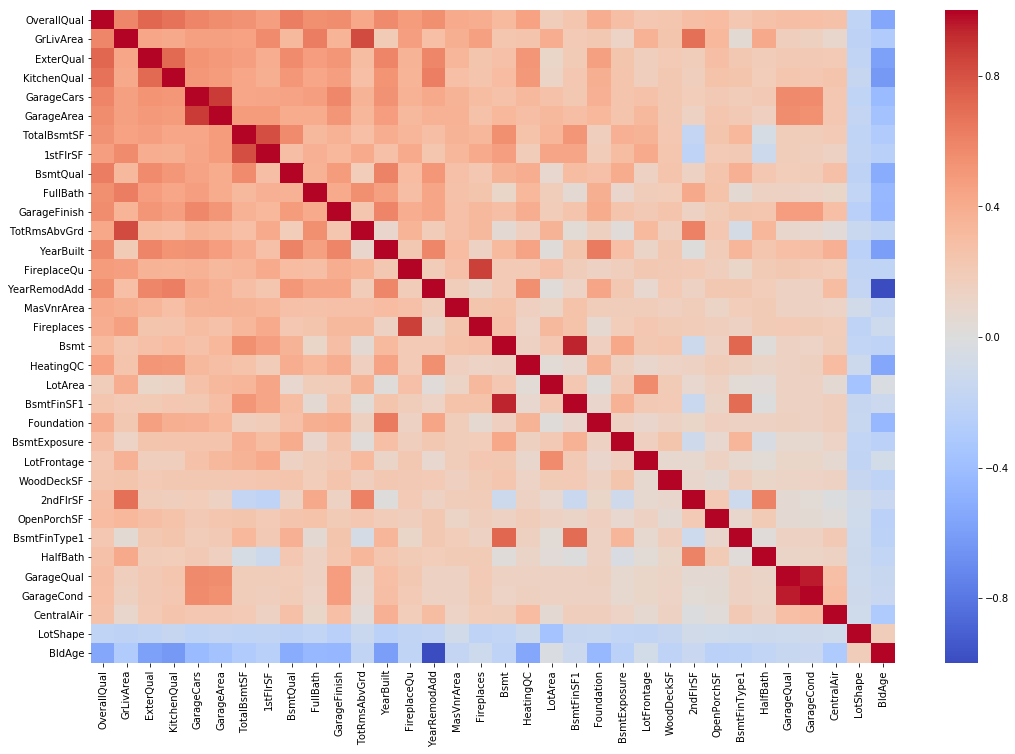

In [15]:
def corr2sales():
    sales_corr = df_no_na.corr()['SalePrice'].sort_values(ascending=False).drop("SalePrice")
    high_corr = sales_corr[(sales_corr >= 0.25) | (sales_corr <= -0.25)].index.tolist()
    print("Variables, highly correlated to SalesPrice:\n{}".format(high_corr))
    hcorr = df_no_na[high_corr].corr()
    print("Between-variable correlations")
    plt.figure(figsize=(18,12))
    sns.heatmap(hcorr, xticklabels=hcorr.columns, yticklabels=hcorr.columns, cmap='coolwarm')
    return sales_corr
sales_corr = corr2sales()

Now lets take variables with low correlation and convert them into indicator variables (if possible) that will hopefully have high correlation with `SalePrice`.

In [16]:
low_corr = sales_corr[(sales_corr < 0.25) & (sales_corr > -0.25)].index.tolist()
print(low_corr)

df_no_na['HasPool'] = (df_no_na['PoolQC'] != tp_qual.categories.get_loc('NA')).astype(int)
df_no_na['HasFence'] = (df_no_na['Fence'] != tp_fence.categories.get_loc('NA')).astype(int)

['PavedDrive', 'BsmtFullBath', 'RoofStyle', 'BsmtUnfSF', 'SaleCondition', 'BsmtCond', 'HouseStyle', 'BedroomAbvGr', 'RoofMatl', 'Location', 'PoolQC', 'ScreenPorch', 'Functional', 'Exterior2nd', 'Exterior1st', 'PoolArea', 'Condition1', '3SsnPorch', 'MoSold', 'Street', 'ExterCond', 'LandContour', 'Utilities', 'Condition2', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtHalfBath', 'YrSold', 'LowQualFinSF', 'LandSlope', 'SaleType', 'MiscVal', 'LotConfig', 'OverallCond', 'MSSubClass', 'BldgType', 'Heating', 'EnclosedPorch', 'KitchenAbvGr', 'Fence', 'MSZoning', 'RenovationAfter', 'MSClass']


Variables, highly correlated to SalesPrice:
['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'Bsmt', 'HeatingQC', 'LotArea', 'BsmtFinSF1', 'Foundation', 'BsmtExposure', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtFinType1', 'HalfBath', 'GarageQual', 'GarageCond', 'CentralAir', 'LotShape', 'BldAge']
Between-variable correlations


-0.1721839440381199

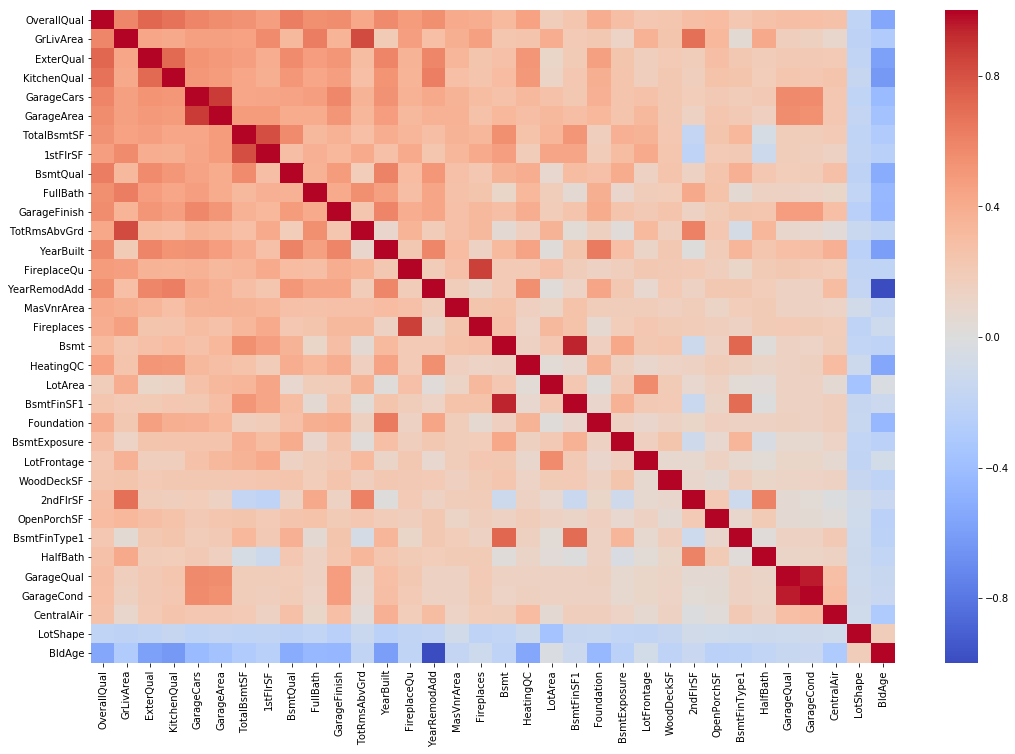

In [17]:
corr2sales()['HasFence']

In [18]:
df_no_na.corr().to_csv('corr.csv')

Let's now try different subsets of variables as predictors.

In [19]:
predictor_vars_corr5 = [
    'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageArea'
]

predictor_vars_corr10 = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'
]

predictor_vars_corr10_no_covar = [
    'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'
]

# those with correlation to SalePrice greater than 0.3
predictor_vars_corr_g3_no_covar = [
    'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
    'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF', 'OpenPorchSF'
]

Exploring the type of dependency between the chosen variables in `high_correlation_vars` and the target variable `SalePrice`

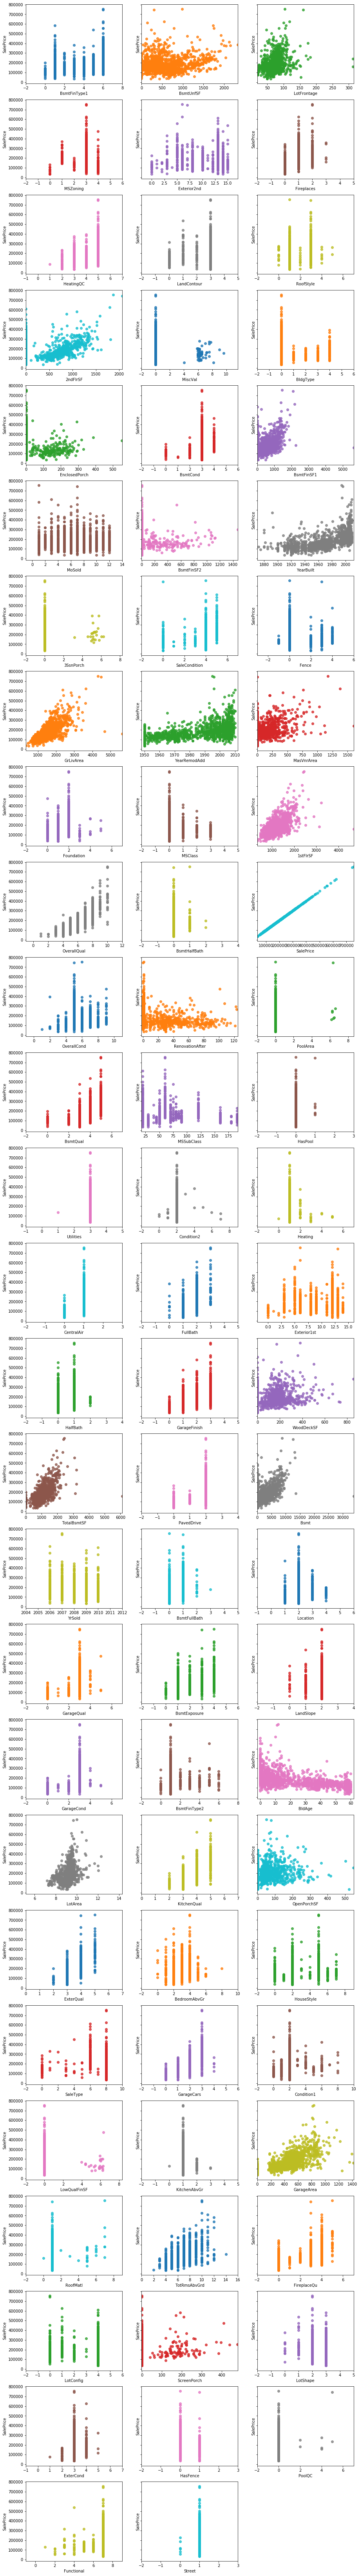

In [20]:
# Remove outliers
# df_no_na = df_no_na[(np.abs(sp.stats.zscore(df_no_na)) < 4).all(axis=1)]
# print(len((np.abs(sp.stats.zscore(df_no_na)) < 4).all(axis=1)))

all_vars = set(df_no_na.columns.values.tolist()) - set(excluded_vars)
nvars = len(all_vars)
m = 3
n = (nvars // m + 1) if nvars % m else int(nvars / m)
fig, ax = plt.subplots(n, m, figsize=(15, 120), sharey=True)

i, j = 0, 0
log_transform_vars = []
sq_transform_vars = []
exp_transform_vars = []

def apply_transform(v, X):
    if v in log_transform_vars:
        var = np.log(X[v])
    elif v in sq_transform_vars:
        var = np.square(X[v])
    elif v in exp_transform_vars:
        var = np.exp(X[v])
    else:
        var = X[v]
    return var

for v in all_vars:
    var = apply_transform(v, df_no_na)
    sns.regplot(x=var, y=df_no_na["SalePrice"], fit_reg=False, ax=ax[i][j])
    ax[i][j].set_xlim(min(var) - 2, max(var) + 2)
    if j + 1 < m:
        j = j + 1
    elif j + 1 == m:
        if i + 1 <= n:
            if i + 1 != n:
                j = 0
            else:
                j += 1
            i = i + 1    

while i != n and j != m:
    ax[i][j].axis('off')
    if j + 1 < m:
        j += 1
    elif j + 1 == m:
        if i == n: j += 1
        else:
            j = 0
            i += 1

In [21]:
# +/-0.5 or higher
high_correlation_vars = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'BsmtQual', 
    'FireplaceQu', 'Bsmt', 'LotArea', 'YearBuilt', 'BldAge',
    'Foundation', 'BsmtExposure', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', 
    'HalfBath', 'GarageQual', 'CentralAir', 'ExterQual',
    'MSZoning', 'Street', 'LotConfig', 'LandSlope', 'OverallCond',
    'HeatingQC', '1stFlrSF', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd',
    'Functional', 'EnclosedPorch', 'ScreenPorch', 'SaleCondition',
    'MSClass', 'HasPool'
]

def create_dataset(predictor_vars, df):
    X = df[predictor_vars]
    for v in predictor_vars:
        X[v] = apply_transform(v, X)
    feature_names = X.columns.tolist()
    y = np.log10(df['SalePrice'])
    return X, y

# predictor_vars is declared, so that it's easier to switch between different predictor sets 
# without changing the further code
predictor_vars = high_correlation_vars
X, y = create_dataset(predictor_vars, df_no_na)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Let's explore correlation only between predictor variables.

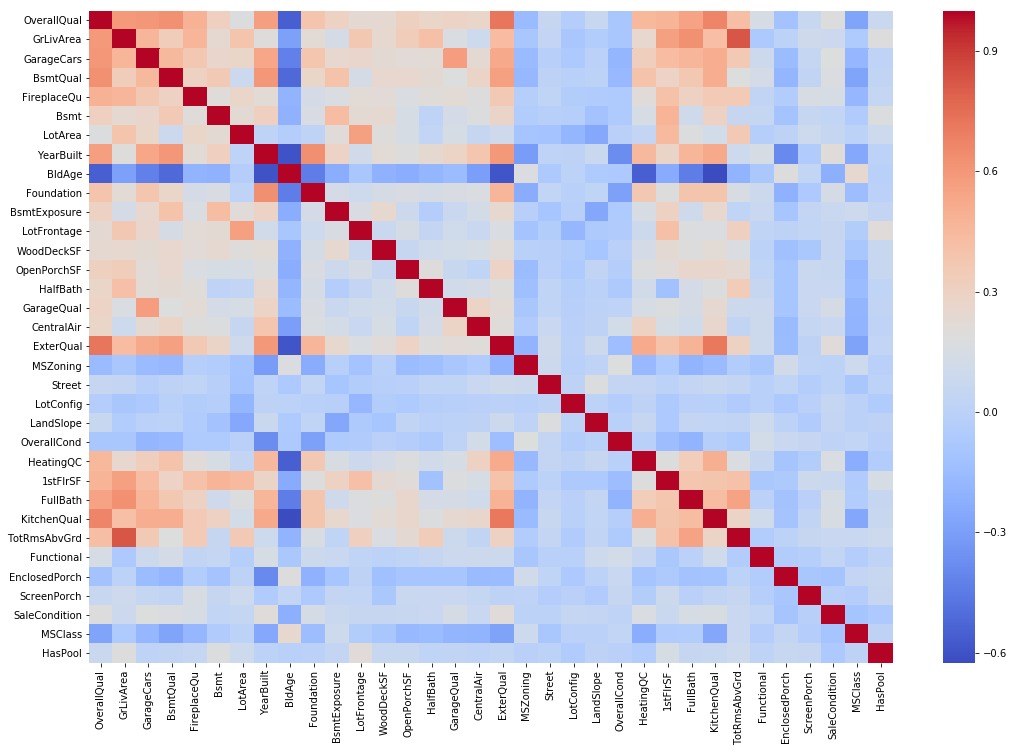

In [22]:
pvcorr = df_no_na[predictor_vars].corr()
plt.figure(figsize=(18,12))
sns.heatmap(pvcorr, xticklabels=pvcorr.columns, yticklabels=pvcorr.columns, cmap="coolwarm")

Let's finaly fit the model

In [23]:
def score_model(estimator, X, y, negate=False):
    """
    The function to evaluate the model according to the competition rules
    `negate` argument is used for hyper-parameter space search, since the `scoring` argument in sklearn
    requires the model quality metric, i.e. the higher the better
    """
    y_true = np.power(10, y)
    y_pred = np.power(10, estimator.predict(X))
    res = np.sqrt(mean_squared_log_error(y_true, y_pred))
    if negate: res *= -1
    return res 
    
neg_score_model = partial(score_model, negate=True)


def search(model, params, X, y, mode='random'):
    """
    Perform a hyper-parameter search for a `model` over the `params`
    trying to predict `y` using `X` using the search type `mode`
    """
    if mode == 'random':
        reg = RandomizedSearchCV(model, params, n_iter=500, scoring=neg_score_model)
    elif mode == 'grid':
        reg = GridSearchCV(model, params, scoring=neg_score_model)
    else:
        raise NotImplementedError("This mode is not implemented yet!")
    reg.fit(X, y)
    print("Best score: {}\nWith parameters: {}".format(reg.best_score_, reg.best_estimator_))
    return reg.best_estimator_


def fit_model(X, predictor_vars, y, cand, cand_params, do_search=False):
    """
    Fit the model to data and either by doing hyper-parameter search (if `do_search` is True) for `cand` over
    `cand_params` and returing the best performing model after CV or by just fitting the data.
    """
    if do_search:
        reg = search(cand, cand_params, X, y, mode='grid')
        return reg, reg.best_estimator_.fit(X)
    else:
        reg = cand
        scores = cross_val_score(reg, X, y, scoring=score_model, cv=10)
        print("CV MSLE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
        reg.fit(X, y)
        y_hat = reg.predict(X)
        r_sq = r2_score(y, y_hat)
        print("R squared: {}".format(r_sq))
        p = len(predictor_vars)
        n = len(X)
        adj_coef = p / (n - p - 1)
        print("Adjusted R squared: {}".format(r_sq - adj_coef * (1 - r_sq)))
        print("Residual MSLE: {}".format(
            np.sqrt(sum((np.log(y + 1) - np.log(y_hat + 1)) ** 2) / (n - p - 1))
        ))
        return reg, y_hat, r_sq

xgr = xgb.XGBRegressor() # gives lower CV MSE, but overfits
xgr_params = {
    'max_depth': [5],
    'colsample_bytree': [0.75],
    'n_estimators': [100],
    'learning_rate': sp.stats.uniform(0.1, 0.099)
}

ridge = Ridge()
ridge_params = {
    'alpha': np.arange(0, 5, 0.5)
}

cand, cand_params = ridge, ridge_params
reg, y_hat, r2 = fit_model(X, predictor_vars, y, cand, None)

CV MSLE: 0.1403 (+/- 0.0770)
R squared: 0.8852939582319447
Adjusted R squared: 0.8825571123230929
Residual MSLE: 0.009548766018253425


Explore the obtained coefficients.

In [24]:
coef_df = pd.DataFrame(reg.coef_.reshape(1, -1), columns=predictor_vars)
coef_df.iloc[:,[i for i, c in enumerate(np.abs(reg.coef_) < 1e-5) if c]]

,Bsmt
0,0.000005


Compute variance inflation factors and check if there's a harmful collinearity between the variables.

In [25]:
def vif(predictors, data):
    """
    Calculating variance inflation factors (VIF) for each of the `predictors` on the data
    More on VIF here: https://onlinecourses.science.psu.edu/stat501/node/347/
    """
    vif_coef = {}
    for p in predictors:
        reg = LinearRegression()
        pvars = list(set(predictors) - set([p]))
        # print("{} ~ {}\n".format(p, " + ".join(pvars)))
        reg.fit(data[pvars], data[p])
        p_hat = reg.predict(data[pvars])
        vif_coef[p] = 1 / (1 - r2_score(data[p].values, p_hat))
    return pd.DataFrame.from_dict(
        vif_coef,#OrderedDict(sorted(vif_coef.items(), key=itemgetter(1))),
        orient='index', columns=['VIF']
    )

vif_df = vif(predictor_vars, X)
# print(max(10, 1 / (1 - r2)))
vif_df['NoCollinearityCheck'] = vif_df['VIF'] < max(10, 1 / (1 - r2))
vif_df

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


,VIF,NoCollinearityCheck
OverallQual,3.821306,True
GrLivArea,7.716836,True
GarageCars,2.806444,True
BsmtQual,2.388670,True
FireplaceQu,1.557287,True
Bsmt,1.687645,True
LotArea,1.964304,True
YearBuilt,5.575609,True
BldAge,2.636919,True
Foundation,1.953540,True


### DOESN'T WORK YET (TAKES TOO LONG)
Try to use the best subsets methods to identify whether any subset of predictors performs better or at the same level with the trained model.

In [ ]:
import cProfile as cp

def best_subsets(dep_var, predictors, data, return_top=3):
    """
    More on best subsets here: http://statisticsbyjim.com/regression/guide-stepwise-best-subsets-regression/
    """
    # the number of predictors to use
    res = []
    for v in range(1, len(predictors)):
        var_sets = combinations(predictors, v)
        stats = {}
        for pvars in var_sets:
            reg = LinearRegression()
            X = data[list(pvars)]
            reg.fit(X, dep_var)
            y_hat = reg.predict(X)
            stats[pvars] = [
                score_model(reg, X, dep_var),
                r2_score(dep_var, y_hat)
            ]
        res.append(
            sorted(stats.items(), key=itemgetter(1))[:return_top] # top 3 are ones with lowest MSLEs
        )
        if v == 3: break # for debugging and testing purposes
            
    header = ['NVars', 'Vars', 'CV MSLE', 'R squared']
    rows = []
    for bm in res:
        for k, v in bm:
            rows.append([len(k), ", ".join(k), v[0], v[1]])
    return pd.DataFrame(rows, columns=header)


cp.run('best_subsets(y, predictor_vars, X)')

Try to port the function to Cython to increase the speed.

In [ ]:
%%cython --annotate
import cProfile as cp
from itertools import combinations
from operator import itemgetter
cimport numpy as np
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error


cdef double cscore_model(estimator, X, y, negate=False):
    cdef double res
    y_true = np.power(10, y)
    y_pred = np.power(10, estimator.predict(X))
    res = np.sqrt(mean_squared_log_error(y_true, y_pred))
    if negate: res *= -1
    return res


def cbest_subsets(dep_var, predictors, data, return_top=3):
    # the number of predictors to use
    res, P = [], len(predictors)
    v = 1
    while True:
        var_sets = list(combinations(predictors, v))
        stats = {}
        for pvars in var_sets:
            reg = LinearRegression()
            X = data[list(pvars)]
            reg.fit(X, dep_var)
            y_hat = reg.predict(X)
            stats[pvars] = [
                cscore_model(reg, X, dep_var),
                r2_score(dep_var, y_hat)
            ]
        res.append(
            sorted(stats.items(), key=itemgetter(1))[:return_top] # top 3 are ones with lowest MSLEs
        )
        if v > P: break
        v += 1
            
    header = ['NVars', 'Vars', 'CV MSLE', 'R squared']
    rows = []
    for bm in res:
        for k, v in bm:
            rows.append([len(k), ", ".join(k), v[0], v[1]])
    return header, rows

In [ ]:
header, rows = cbest_subsets(y, predictor_vars, X)
bdf = pd.DataFrame(rows, columns=header)
bdf

Plot residuals vs fitted values and check for any patterns (no pattern should be there!).

In [ ]:
def analyze_residuals(y, y_hat, plot=True):
    """
    Return 2 highest residuals and optionaly plot residuals vs fitted values
    """
    residuals = y - y_hat
    if plot:
        sns.regplot(
            pd.Series(y_hat, name="Fitted values"),
            pd.Series(residuals, name="Residuals"),
            fit_reg=False
        )
    abs_residuals = np.abs(residuals)
    highest_residuals = abs_residuals.argsort()[-2:]
    return highest_residuals

highest_residuals = analyze_residuals(y, y_hat)
df_no_na.iloc[highest_residuals,:]

In [ ]:
def residuals_vs_predictors(predictors, data, y, y_hat):
    """
    Plot residuals vs predictor variables
    """
    residuals = y - y_hat
    for p in predictors:
        plt.figure()
        sns.regplot(p, residuals, fit_reg=False, data=data)

residuals_vs_predictors(predictor_vars, X, y, y_hat)

A normal plot of residuals (QQ plot). More on this topic here: https://www.itl.nist.gov/div898/handbook/eda/section3/normprpl.htm

In [ ]:
nds = sp.stats.norm()
std_residuals = (y - y_hat)
qq = np.arange(0, 1, 1 / len(std_residuals))

nquantiles = nds.ppf(qq)
plt.plot(nquantiles, nquantiles)
plt.scatter(nquantiles, np.percentile(std_residuals, qq * 100))
# Sanity check: draw sample from standard normal
# plt.scatter(nquantiles, np.percentile(np.random.normal(loc=0, scale=1, size=len(std_residuals)), qq * 100))
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(y - y_hat)

Now let's use our best model to predict the `SalesPrice` for the test set.
#### Note that any added variables during the experimentations with training procedure should be added to `transform_vars` function below.

In [ ]:
def transform_vars(tdf, nominal_le_encoders, skewed_features):
    for skf in skewed_features:
        sk = skew[skew == skf].index[0]
        tdf[sk] = np.log1p(tdf[sk])
        
    for nnv in na_nominal_vars:
        tdf.drop(nnv, axis=1, inplace=True)

    tdf.drop('Electrical', axis=1, inplace=True)
    for nov in na_ordinal_vars:
        tdf[nov].fillna('NA', inplace=True)
        tdf[nov] = tdf[nov].astype(na_ordinal_vars[nov]).cat.codes

    for ncv in na_cont_vars:
        tdf[ncv].fillna(tdf[ncv].median(), inplace=True)
    
    for ov in ordinal_vars:
        tdf[ov].fillna(tdf[ov].mode().squeeze(), inplace=True)
        tdf[ov] = tdf[ov].astype(ordinal_vars[ov]).cat.codes

    for nv in set(nominal_vars) - set(excluded_vars):
        tdf[nv].fillna(tdf[nv].mode().squeeze(), inplace=True)
        tdf[nv] = nominal_le_encoders[nv].transform(tdf[nv])
        
    for nmv in cont_or_discrete_vars:
        tdf[nmv].fillna(tdf[nmv].median(), inplace=True)

    tdf['Bsmt'] = tdf['BsmtFinSF1'] * tdf['BsmtFinType1'] + tdf['BsmtFinSF2'] * tdf['BsmtFinType2']
    tdf['BldAge'] = tdf['YrSold'] - tdf['YearRemodAdd']
    tdf['RenovationAfter'] = tdf['YearRemodAdd'] - tdf['YearBuilt']
    tdf['MSClass'] = tdf['MSSubClass'].apply(mssub2class)
    tdf['HasPool'] = (tdf['PoolQC'] != tp_qual.categories.get_loc('NA')).astype(int)


tdf = pd.read_csv('data/test.csv')
tdf = tdf.set_index('Id')
transform_vars(tdf, le_encoders, skewed_features)
tX = tdf[predictor_vars]
for v in predictor_vars:
    tX[v] = transform_var(v, tX)
tX['SalePrice'] = np.power(10, reg.predict(tX))
tX.head()


In [ ]:
tX[['SalePrice']].to_csv('output_xgr_check.csv')